In [2]:
from google.colab import drive
#我的雲端硬碟
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import shap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [4]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [5]:
#讀取資料
data=pd.read_csv("/content/drive/MyDrive/Sleep_health_and_lifestyle_dataset.csv")

In [13]:
data.describe()

Person ID         Age  Sleep Duration  Quality of Sleep  \
count  374.000000  374.000000      374.000000        374.000000   
mean   187.500000   42.184492        7.132086          7.312834   
std    108.108742    8.673133        0.795657          1.196956   
min      1.000000   27.000000        5.800000          4.000000   
25%     94.250000   35.250000        6.400000          6.000000   
50%    187.500000   43.000000        7.200000          7.000000   
75%    280.750000   50.000000        7.800000          8.000000   
max    374.000000   59.000000        8.500000          9.000000   

       Physical Activity Level  Stress Level  Heart Rate   Daily Steps  
count               374.000000    374.000000  374.000000    374.000000  
mean                 59.171123      5.385027   70.165775   6816.844920  
std                  20.830804      1.774526    4.135676   1617.915679  
min                  30.000000      3.000000   65.000000   3000.000000  
25%                  45.000000      4.000000   68.000000   5600.000000  
50%                  60.000000      5.000000   70.000000   7000.000000  
75%                  75.000000      7.000000   72.000000   8000.000000  
max                  90.000000      8.000000   86.000000  10000.000000

In [152]:
columns = [column for column in data.columns if column!='Person ID']
for column in columns:
    unique_values = data[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'Gender': ['Male' 'Female']
Unique values in 'Age': [27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 48 49 50 51 52
 53 54 55 56 57 58 59]
Unique values in 'Occupation': ['Software Engineer' 'Doctor' 'Sales Representative' 'Teacher' 'Nurse'
 'Engineer' 'Accountant' 'Scientist' 'Lawyer' 'Salesperson' 'Manager']
Unique values in 'Sleep Duration': [6.1 6.2 5.9 6.3 7.8 6.  6.5 7.6 7.7 7.9 6.4 7.5 7.2 5.8 6.7 7.3 7.4 7.1
 6.6 6.9 8.  6.8 8.1 8.3 8.5 8.4 8.2]
Unique values in 'Quality of Sleep': [6 4 7 5 8 9]
Unique values in 'Physical Activity Level': [42 60 30 40 75 35 45 50 32 70 80 55 90 47 65 85]
Unique values in 'Stress Level': [6 8 7 4 3 5]
Unique values in 'BMI Category': ['Overweight' 'Normal' 'Obese' 'Normal Weight']
Unique values in 'Blood Pressure': ['126/83' '125/80' '140/90' '120/80' '132/87' '130/86' '117/76' '118/76'
 '128/85' '131/86' '128/84' '115/75' '135/88' '129/84' '130/85' '115/78'
 '119/77' '121/79' '125/82' '135/90' '122/80' '142/92' '140/95

In [6]:
import pandas as pd

# 假設 data 是你的 DataFrame

# 刪除 Person ID
data = data.drop(columns=["Person ID"])

# 把 blood pressure 分成兩個欄位
data[["BloodPressure_Upper", "BloodPressure_Lower"]] = data["Blood Pressure"].str.split("/", expand=True).astype(float)

# 分類 Physical Activity Level
data["Physical Activity Level"] = pd.cut(
    data["Physical Activity Level"],
    bins=[-float("inf"), 35, 45, 60, 75, 90],
    labels=["<=35", "<=45", "<=60", "<=75", "<=90"]
)

# 分類 Daily Steps
data["Daily Steps"] = pd.cut(
    data["Daily Steps"],
    bins=[-float("inf"), 5000, 6000, 7000, float("inf")],
    labels=["<=5000", "<=6000", "<=7000", "7000up"]
)

# 將睡眠疾病轉換為 0 和 1
data["Sleep Disorder"] = data["Sleep Disorder"].apply(lambda x: 0 if pd.isna(x) else 1)

# 分類 BMI
data["BMI Category"] = data["BMI Category"].replace({
    "Normal Weight": "Normal",
    "Obese": "Overweight"
})

# 分類 Quality of Sleep
data["Quality of Sleep"] = data["Quality of Sleep"].apply(lambda x: "4-5" if x in [4, 5] else x)

# 分類 Occupation
data["Occupation"] = data["Occupation"].replace({
    "Manager": "Salesperson",
    "Sales Representative": "Salesperson",
    "Software Engineer": "Engineer"
})
# 刪除 Bloodpressure
data = data.drop(columns=["Blood Pressure"])

In [7]:
data['Sleep Disorder'] = data['Sleep Disorder'].astype("category")


In [8]:
categorical_columns = data.select_dtypes(include=["object", "category"]).columns

# 初始化 LabelEncoder
label_encoders = {}

# 對每個類別型欄位進行編碼
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))  # 確保所有值轉為字串處理
    label_encoders[col] = le  # 儲存編碼器以供後續解碼使用

# 檢查結果
print("經過 Label Encoding 的資料：")
print(data.head())

print("\n各欄位的編碼對應：")
for col, le in label_encoders.items():
    print(f"{col}: {list(le.classes_)}")

經過 Label Encoding 的資料：
   Gender  Age  Occupation  Sleep Duration  Quality of Sleep  \
0       1   27           2             6.1                 1   
1       1   28           1             6.2                 1   
2       1   28           1             6.2                 1   
3       1   28           5             5.9                 0   
4       1   28           5             5.9                 0   

   Physical Activity Level  Stress Level  BMI Category  Heart Rate  \
0                        1             6             1          77   
1                        2             8             0          75   
2                        2             8             0          75   
3                        0             8             1          85   
4                        0             8             1          85   

   Daily Steps  Sleep Disorder  BloodPressure_Upper  BloodPressure_Lower  
0            1               0                126.0                 83.0  
1            0       

In [ ]:
data['Quality of Sleep'].unique()
data['Occupation'].unique()

array([2, 1, 5, 7, 4, 0, 6, 3])

In [10]:
data['Sleep Disorder'].unique()

array([0, 1])

In [9]:
id=pd.read_csv("/content/drive/MyDrive/Sleep_health_and_lifestyle_dataset.csv")

In [49]:
x_feature_names = data.drop(['Sleep Disorder'], axis=1).columns
y_label_names = ['Yes','No']
data['Person ID']=id['Person ID']#13是person id
X = data.drop(['Sleep Disorder'], axis=1).values # 移除y並取得剩下欄位資料
y = data['Sleep Disorder'].values # 取得病人糖尿病結果作為y
# 假設只選擇部分變數

X_traino, X_testo, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train=X_traino[:,:][:,:12]
X_test=X_testo[:,:][:,:12]
print('train shape:', X_train.shape)
print('test shape:', X_test.shape)

train shape: (299, 12)
test shape: (75, 12)


In [50]:
import xgboost as xgb

# 初始化 XGBoostClassifier
model = xgb.XGBClassifier(
    use_label_encoder=False,
    # 禁用舊版的 Label Encoding
    eval_metric="logloss",    # 選擇評估指標
    n_estimators=100,         # 樹的數量
    max_depth=6,              # 樹的深度
    learning_rate=0.1,        # 學習率
    subsample=0.8,            # 子樣本比例
    colsample_bytree=0.8      # 特徵子集比例
)

# 使用訓練資料訓練模型
model.fit(X_train, y_train)
# 預測
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 模型評估
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"AUC Score: {auc_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.96
AUC Score: 0.962976539589443
Confusion Matrix:
[[43  1]
 [ 2 29]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        44
           1       0.97      0.94      0.95        31

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:19:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [20]:
x_feature_names

Index(['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate',
       'Daily Steps', 'BloodPressure_Upper', 'BloodPressure_Lower'],
      dtype='object')

In [21]:
# 獲取特徵重要性
importance = model.feature_importances_
feature_importance = pd.DataFrame({
    "Feature": x_feature_names,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

print("特徵重要性排序：")
print(feature_importance)

特徵重要性排序：
                    Feature  Importance
7              BMI Category    0.770914
2                Occupation    0.064250
10      BloodPressure_Upper    0.047450
4          Quality of Sleep    0.029511
8                Heart Rate    0.020871
11      BloodPressure_Lower    0.013074
9               Daily Steps    0.012363
6              Stress Level    0.010763
3            Sleep Duration    0.008662
1                       Age    0.008084
0                    Gender    0.007414
5   Physical Activity Level    0.006643


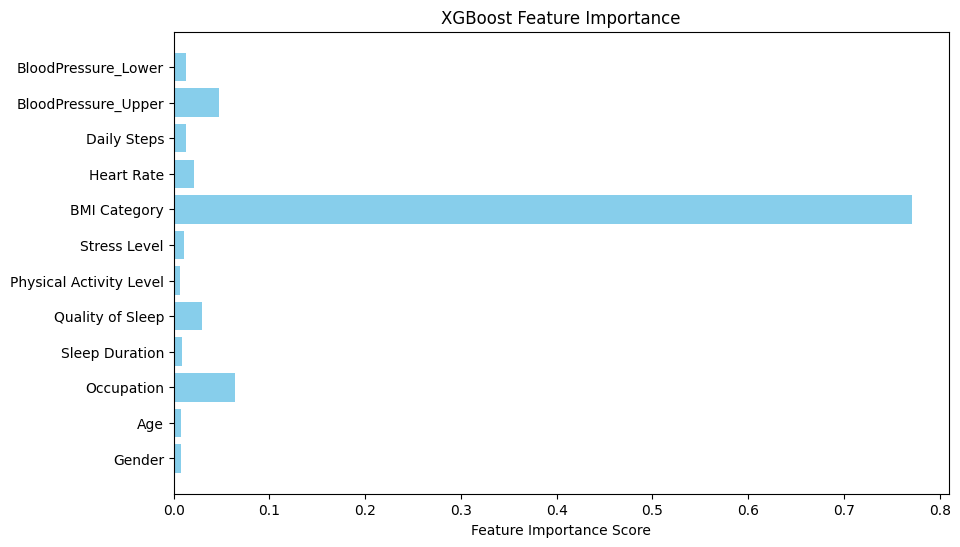

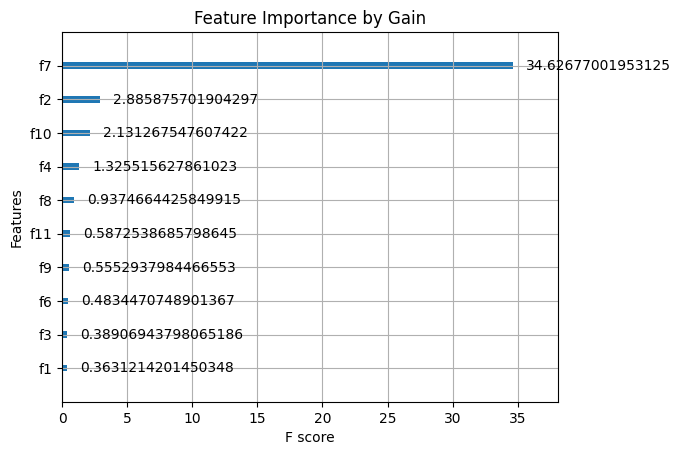

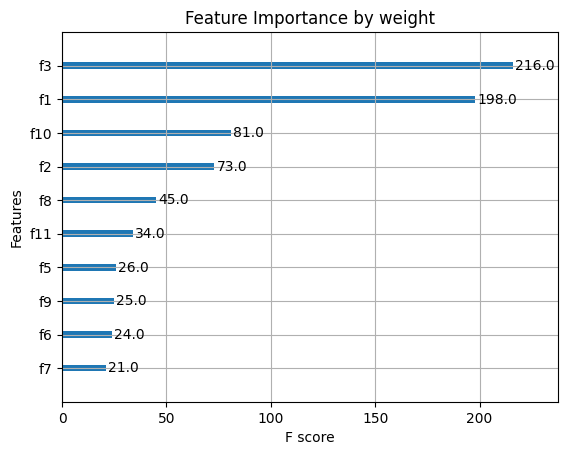

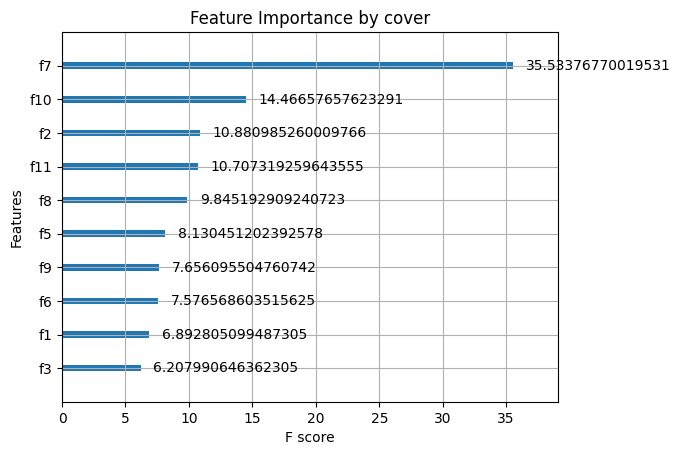

In [22]:
# 使用內建方法顯示特徵重要性
importances = model.feature_importances_

# 視覺化特徵重要性
plt.figure(figsize=(10, 6))
plt.barh(x_feature_names, importances, color="skyblue")
plt.xlabel("Feature Importance Score")
plt.title("XGBoost Feature Importance")
plt.show()

# 內建的特徵重要性圖（基於 Gain）
xgb.plot_importance(model,importance_type="gain", max_num_features=10, title="Feature Importance by Gain")
plt.show()
# 內建的特徵重要性圖（基於 weight）
xgb.plot_importance(model,importance_type="weight", max_num_features=10, title="Feature Importance by weight")
plt.show()
# 內建的特徵重要性圖（基於 weight）
xgb.plot_importance(model,importance_type="cover", max_num_features=10, title="Feature Importance by cover")
plt.show()

In [363]:
data

Gender  Age  Occupation  Sleep Duration  Quality of Sleep  \
0         1   27           2             6.1                 1   
1         1   28           1             6.2                 1   
2         1   28           1             6.2                 1   
3         1   28           5             5.9                 0   
4         1   28           5             5.9                 0   
..      ...  ...         ...             ...               ...   
369       0   59           4             8.1                 4   
370       0   59           4             8.0                 4   
371       0   59           4             8.1                 4   
372       0   59           4             8.1                 4   
373       0   59           4             8.1                 4   

     Physical Activity Level  Stress Level  BMI Category  Heart Rate  \
0                          1             6             1          77   
1                          2             8             0          75   
2                          2             8             0          75   
3                          0             8             1          85   
4                          0             8             1          85   
..                       ...           ...           ...         ...   
369                        3             3             1          68   
370                        3             3             1          68   
371                        3             3             1          68   
372                        3             3             1          68   
373                        3             3             1          68   

     Daily Steps  Sleep Disorder  BloodPressure_Upper  BloodPressure_Lower  \
0              1               0                126.0                 83.0   
1              0               0                125.0                 80.0   
2              0               0                125.0                 80.0   
3              1               1                140.0                 90.0   
4              1               1                140.0                 90.0   
..           ...             ...                  ...                  ...   
369            3               1                140.0                 95.0   
370            3               1                140.0                 95.0   
371            3               1                140.0                 95.0   
372            3               1                140.0                 95.0   
373            3               1                140.0                 95.0   

     Person ID  
0            1  
1            2  
2            3  
3            4  
4            5  
..         ...  
369        370  
370        371  
371        372  
372        373  
373        374  

[374 rows x 14 columns]

In [ ]:
import shap

In [23]:
xgb_explainer = shap.TreeExplainer(model=model, data=X_train)
shap_values = xgb_explainer.shap_values(X_test)  # 使用 logit_link
#xgb_explainer = shap.TreeExplainer(model=model, data=X_train, link="logit")
#shap_values = xgb_explainer.shap_values(X_test)
print(shap_values.shape)

(75, 12)


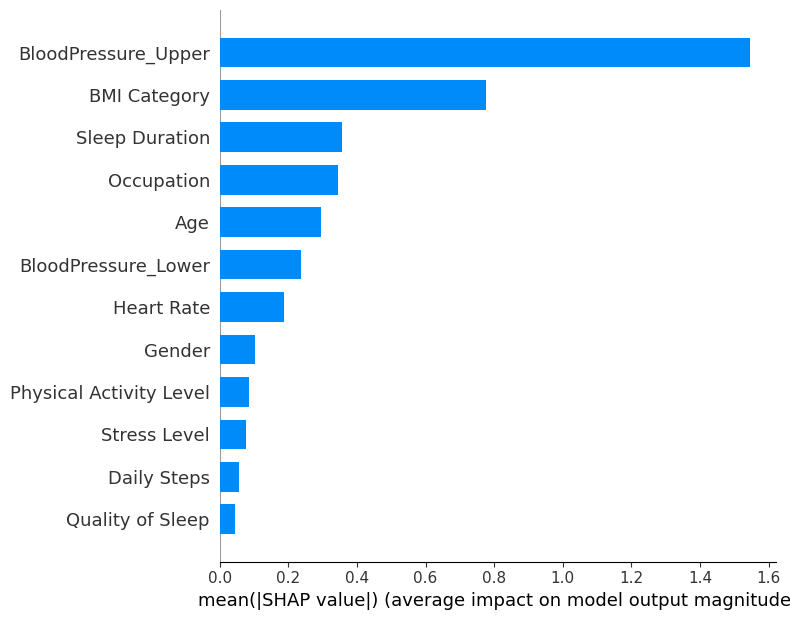

In [24]:
shap.summary_plot(shap_values, X_test, plot_type="bar",
         class_names= y_label_names,
         feature_names = x_feature_names)

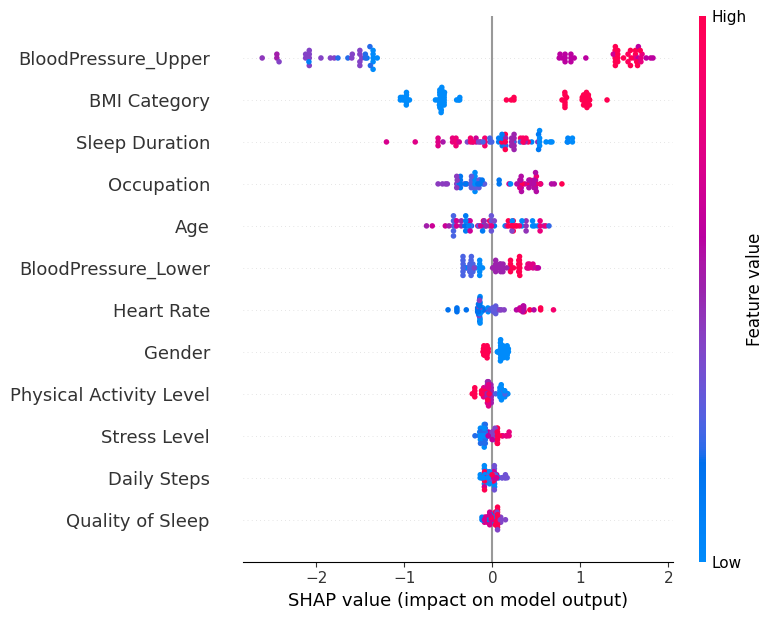

In [25]:
shap.summary_plot(shap_values, X_test,
         class_names= y_label_names,
         feature_names = x_feature_names)

In [26]:
# 觀察測試集中第一筆資料預測為Yes的重要程度
shap.initjs()
index=73
sample = X_test[index:index + 1]
prediction = model.predict(sample)[0]
pred_proba = model.predict_proba(sample)[:, 1]
print(f'測試集第 {index+1} 筆模型原始結果: {y_test[index:index+1]}')
print(f'測試集第 {index+1} 筆模型預測結果: {pred_proba}、label:{prediction}')
shap.force_plot(xgb_explainer.expected_value,
        shap_values[:,:][index],
        X_test[index],
        feature_names=x_feature_names)

測試集第 74 筆模型原始結果: [1]
測試集第 74 筆模型預測結果: [0.9420828]、label:1


array([  0.,  50.,   4.,   6.,   1.,   4.,   8.,   1.,  75.,   0., 140.,
        95.])

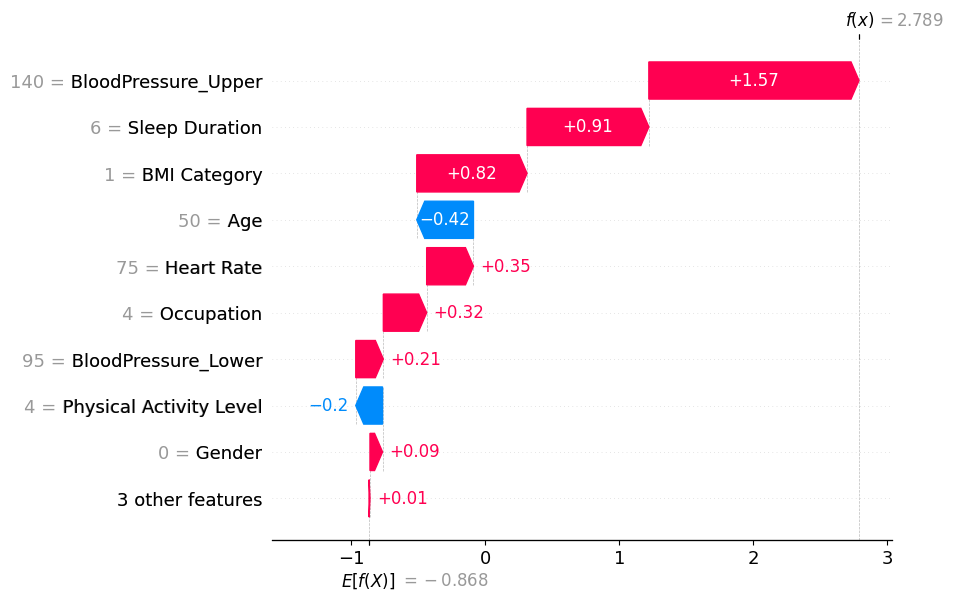

In [27]:
index=73
display(X_test[index,:])
shap.waterfall_plot(shap.Explanation(values=shap_values[:,:][index],
                  base_values=xgb_explainer.expected_value,
                  data=X_test[index,:],
                  feature_names=x_feature_names))

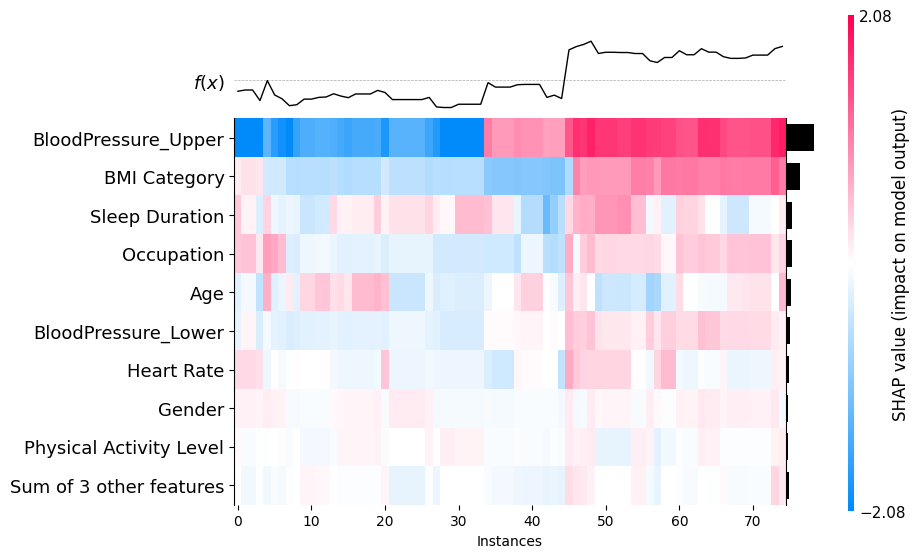

<Axes: xlabel='Instances'>

In [28]:

shap_explanation = shap.Explanation(values=shap_values,
                  base_values=xgb_explainer.expected_value,
                  data=X_test,
                  feature_names=x_feature_names)
shap.plots.heatmap(shap_explanation)

In [29]:
x_feature_names

Index(['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate',
       'Daily Steps', 'BloodPressure_Upper', 'BloodPressure_Lower'],
      dtype='object')

### 分類錯誤的資料

In [30]:

# 比較預測值與真實值
misclassified_indices = (y_pred != y_test)  # 錯誤分類的布林陣列
# 提取錯誤分類的數據
X_test_misclassified = X_testo[misclassified_indices]
y_test_misclassified = y_test[misclassified_indices]
y_pred_misclassified = y_pred[misclassified_indices]
x_feature_names = data.drop(['Sleep Disorder'], axis=1).columns
# 將錯誤分類數據整理成表格
misclassified_df = pd.DataFrame(X_test_misclassified, columns=x_feature_names)
#misclassified_df["Actual"] = y_test_misclassified
#misclassified_df["Predicted"] = y_pred_misclassified
misclassified_df

Gender   Age  Occupation  Sleep Duration  Quality of Sleep  \
0     0.0  59.0         4.0             8.1               4.0   
1     1.0  43.0         2.0             7.8               3.0   
2     1.0  33.0         1.0             6.0               1.0   

   Physical Activity Level  Stress Level  BMI Category  Heart Rate  \
0                      3.0           3.0           1.0        68.0   
1                      4.0           5.0           0.0        70.0   
2                      0.0           8.0           0.0        72.0   

   Daily Steps  BloodPressure_Upper  BloodPressure_Lower  Person ID  
0          3.0                140.0                 95.0      360.0  
1          0.0                130.0                 85.0      202.0  
2          1.0                125.0                 80.0       68.0

In [31]:
data_org=pd.read_csv("/content/drive/MyDrive/Sleep_health_and_lifestyle_dataset.csv")

In [32]:
misclassified_data2 = data_org[data_org["Person ID"].isin(misclassified_df["Person ID"].values.tolist())]

misclassified_data2

Person ID  Gender  Age Occupation  Sleep Duration  Quality of Sleep  \
67          68    Male   33     Doctor             6.0                 6   
201        202    Male   43   Engineer             7.8                 8   
359        360  Female   59      Nurse             8.1                 9   

     Physical Activity Level  Stress Level BMI Category Blood Pressure  \
67                        30             8       Normal         125/80   
201                       90             5       Normal         130/85   
359                       75             3   Overweight         140/95   

     Heart Rate  Daily Steps Sleep Disorder  
67           72         5000       Insomnia  
201          70         8000       Insomnia  
359          68         7000            NaN

### 篩選變數後

In [114]:
data

Gender  Age  Occupation  Sleep Duration  Quality of Sleep  \
0         1   27           2             6.1                 1   
1         1   28           1             6.2                 1   
2         1   28           1             6.2                 1   
3         1   28           5             5.9                 0   
4         1   28           5             5.9                 0   
..      ...  ...         ...             ...               ...   
369       0   59           4             8.1                 4   
370       0   59           4             8.0                 4   
371       0   59           4             8.1                 4   
372       0   59           4             8.1                 4   
373       0   59           4             8.1                 4   

     Physical Activity Level  Stress Level  BMI Category  Heart Rate  \
0                          1             6             1          77   
1                          2             8             0          75   
2                          2             8             0          75   
3                          0             8             1          85   
4                          0             8             1          85   
..                       ...           ...           ...         ...   
369                        3             3             1          68   
370                        3             3             1          68   
371                        3             3             1          68   
372                        3             3             1          68   
373                        3             3             1          68   

     Daily Steps  Sleep Disorder  BloodPressure_Upper  BloodPressure_Lower  \
0              1               0                126.0                 83.0   
1              0               0                125.0                 80.0   
2              0               0                125.0                 80.0   
3              1               1                140.0                 90.0   
4              1               1                140.0                 90.0   
..           ...             ...                  ...                  ...   
369            3               1                140.0                 95.0   
370            3               1                140.0                 95.0   
371            3               1                140.0                 95.0   
372            3               1                140.0                 95.0   
373            3               1                140.0                 95.0   

     Person ID  
0            1  
1            2  
2            3  
3            4  
4            5  
..         ...  
369        370  
370        371  
371        372  
372        373  
373        374  

[374 rows x 14 columns]

In [126]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

# 初始化 KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=45)
selected_features = [2,11] #2 8 11
# 使用選定的特徵
X_try = data.iloc[:, selected_features].values

# 進行交叉驗證
cv_results = []

for train_idx, valid_idx in kfold.split(X_try):
    X_train, X_valid = X_try[train_idx], X_try[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    # 轉換為 DMatrix 格式
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    # 訓練模型
    model = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8
    )

    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=True)

    # 預測並評估
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    cv_results.append(accuracy)

# 輸出結果
print("Cross-Validation Accuracy Scores:", cv_results)
print("Mean Accuracy:", np.mean(cv_results))


[0]	validation_0-logloss:0.61716
[1]	validation_0-logloss:0.56399
[2]	validation_0-logloss:0.53101
[3]	validation_0-logloss:0.49297
[4]	validation_0-logloss:0.47024
[5]	validation_0-logloss:0.45168
[6]	validation_0-logloss:0.42708
[7]	validation_0-logloss:0.41297
[8]	validation_0-logloss:0.39302
[9]	validation_0-logloss:0.38127
[10]	validation_0-logloss:0.37326
[11]	validation_0-logloss:0.36627
[12]	validation_0-logloss:0.35250
[13]	validation_0-logloss:0.34202
[14]	validation_0-logloss:0.33296
[15]	validation_0-logloss:0.32593
[16]	validation_0-logloss:0.31772
[17]	validation_0-logloss:0.31415
[18]	validation_0-logloss:0.31162
[19]	validation_0-logloss:0.30745
[20]	validation_0-logloss:0.30330
[21]	validation_0-logloss:0.30184
[22]	validation_0-logloss:0.30103
[23]	validation_0-logloss:0.29802
[24]	validation_0-logloss:0.29477
[25]	validation_0-logloss:0.29505
[26]	validation_0-logloss:0.29327
[27]	validation_0-logloss:0.29114
[28]	validation_0-logloss:0.28950
[29]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:03:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	validation_0-logloss:0.28319
[41]	validation_0-logloss:0.28337
[42]	validation_0-logloss:0.28353
[43]	validation_0-logloss:0.28398
[44]	validation_0-logloss:0.28392
[45]	validation_0-logloss:0.28388
[46]	validation_0-logloss:0.28414
[47]	validation_0-logloss:0.28434
[48]	validation_0-logloss:0.28450
[49]	validation_0-logloss:0.28269
[50]	validation_0-logloss:0.28112
[51]	validation_0-logloss:0.28103
[52]	validation_0-logloss:0.28194
[53]	validation_0-logloss:0.28228
[54]	validation_0-logloss:0.28245
[55]	validation_0-logloss:0.28073
[56]	validation_0-logloss:0.28037
[57]	validation_0-logloss:0.28013
[58]	validation_0-logloss:0.28004
[59]	validation_0-logloss:0.27923
[60]	validation_0-logloss:0.27947
[61]	validation_0-logloss:0.27982
[62]	validation_0-logloss:0.27921
[63]	validation_0-logloss:0.27891
[64]	validation_0-logloss:0.27834
[65]	validation_0-logloss:0.27657
[66]	validation_0-logloss:0.27608
[67]	validation_0-logloss:0.27537
[68]	validation_0-logloss:0.27591
[69]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:03:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[45]	validation_0-logloss:0.42769
[46]	validation_0-logloss:0.42948
[47]	validation_0-logloss:0.43213
[48]	validation_0-logloss:0.43433
[49]	validation_0-logloss:0.43562
[50]	validation_0-logloss:0.43408
[51]	validation_0-logloss:0.43621
[52]	validation_0-logloss:0.43732
[53]	validation_0-logloss:0.43911
[54]	validation_0-logloss:0.43986
[55]	validation_0-logloss:0.44068
[56]	validation_0-logloss:0.44032
[57]	validation_0-logloss:0.43936
[58]	validation_0-logloss:0.43868
[59]	validation_0-logloss:0.44130
[60]	validation_0-logloss:0.44142
[61]	validation_0-logloss:0.44245
[62]	validation_0-logloss:0.44305
[63]	validation_0-logloss:0.44654
[64]	validation_0-logloss:0.44648
[65]	validation_0-logloss:0.44633
[66]	validation_0-logloss:0.44665
[67]	validation_0-logloss:0.44556
[68]	validation_0-logloss:0.44293
[69]	validation_0-logloss:0.44438
[70]	validation_0-logloss:0.44404
[71]	validation_0-logloss:0.44349
[72]	validation_0-logloss:0.44352
[73]	validation_0-logloss:0.44287
[74]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:03:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-logloss:0.23783
[26]	validation_0-logloss:0.23382
[27]	validation_0-logloss:0.22936
[28]	validation_0-logloss:0.22562
[29]	validation_0-logloss:0.22547
[30]	validation_0-logloss:0.22555
[31]	validation_0-logloss:0.22566
[32]	validation_0-logloss:0.22188
[33]	validation_0-logloss:0.22218
[34]	validation_0-logloss:0.22001
[35]	validation_0-logloss:0.22000
[36]	validation_0-logloss:0.21703
[37]	validation_0-logloss:0.21582
[38]	validation_0-logloss:0.21486
[39]	validation_0-logloss:0.21219
[40]	validation_0-logloss:0.21361
[41]	validation_0-logloss:0.21152
[42]	validation_0-logloss:0.21036
[43]	validation_0-logloss:0.21104
[44]	validation_0-logloss:0.20940
[45]	validation_0-logloss:0.20724
[46]	validation_0-logloss:0.20589
[47]	validation_0-logloss:0.20421
[48]	validation_0-logloss:0.20360
[49]	validation_0-logloss:0.20557
[50]	validation_0-logloss:0.20526
[51]	validation_0-logloss:0.20493
[52]	validation_0-logloss:0.20474
[53]	validation_0-logloss:0.20358
[54]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:03:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.46937
[5]	validation_0-logloss:0.44708
[6]	validation_0-logloss:0.42476
[7]	validation_0-logloss:0.40818
[8]	validation_0-logloss:0.39078
[9]	validation_0-logloss:0.37978
[10]	validation_0-logloss:0.36899
[11]	validation_0-logloss:0.35900
[12]	validation_0-logloss:0.34802
[13]	validation_0-logloss:0.33825
[14]	validation_0-logloss:0.33003
[15]	validation_0-logloss:0.32328
[16]	validation_0-logloss:0.31831
[17]	validation_0-logloss:0.31665
[18]	validation_0-logloss:0.31101
[19]	validation_0-logloss:0.30701
[20]	validation_0-logloss:0.30431
[21]	validation_0-logloss:0.30082
[22]	validation_0-logloss:0.29848
[23]	validation_0-logloss:0.29665
[24]	validation_0-logloss:0.29564
[25]	validation_0-logloss:0.29292
[26]	validation_0-logloss:0.29228
[27]	validation_0-logloss:0.29161
[28]	validation_0-logloss:0.29129
[29]	validation_0-logloss:0.29222
[30]	validation_0-logloss:0.29418
[31]	validation_0-logloss:0.29648
[32]	validation_0-logloss:0.29587
[33]	validation_0-lo

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:03:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[33]	validation_0-logloss:0.31125
[34]	validation_0-logloss:0.31064
[35]	validation_0-logloss:0.31133
[36]	validation_0-logloss:0.31093
[37]	validation_0-logloss:0.31077
[38]	validation_0-logloss:0.31068
[39]	validation_0-logloss:0.31035
[40]	validation_0-logloss:0.31117
[41]	validation_0-logloss:0.31075
[42]	validation_0-logloss:0.31030
[43]	validation_0-logloss:0.31080
[44]	validation_0-logloss:0.31044
[45]	validation_0-logloss:0.31059
[46]	validation_0-logloss:0.31043
[47]	validation_0-logloss:0.31019
[48]	validation_0-logloss:0.31054
[49]	validation_0-logloss:0.31197
[50]	validation_0-logloss:0.31205
[51]	validation_0-logloss:0.31239
[52]	validation_0-logloss:0.31226
[53]	validation_0-logloss:0.31255
[54]	validation_0-logloss:0.31237
[55]	validation_0-logloss:0.31348
[56]	validation_0-logloss:0.31324
[57]	validation_0-logloss:0.31294
[58]	validation_0-logloss:0.31315
[59]	validation_0-logloss:0.31293
[60]	validation_0-logloss:0.31286
[61]	validation_0-logloss:0.31281
[62]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:03:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation_0-logloss:0.24112
[39]	validation_0-logloss:0.24007
[40]	validation_0-logloss:0.24086
[41]	validation_0-logloss:0.24039
[42]	validation_0-logloss:0.23953
[43]	validation_0-logloss:0.23939
[44]	validation_0-logloss:0.23846
[45]	validation_0-logloss:0.23837
[46]	validation_0-logloss:0.23838
[47]	validation_0-logloss:0.23762
[48]	validation_0-logloss:0.23771
[49]	validation_0-logloss:0.23872
[50]	validation_0-logloss:0.23857
[51]	validation_0-logloss:0.23815
[52]	validation_0-logloss:0.23692
[53]	validation_0-logloss:0.23645
[54]	validation_0-logloss:0.23600
[55]	validation_0-logloss:0.23662
[56]	validation_0-logloss:0.23665
[57]	validation_0-logloss:0.23642
[58]	validation_0-logloss:0.23655
[59]	validation_0-logloss:0.23627
[60]	validation_0-logloss:0.23594
[61]	validation_0-logloss:0.23557
[62]	validation_0-logloss:0.23521
[63]	validation_0-logloss:0.23649
[64]	validation_0-logloss:0.23625
[65]	validation_0-logloss:0.23557
[66]	validation_0-logloss:0.23549
[67]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:03:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[23]	validation_0-logloss:0.34544
[24]	validation_0-logloss:0.34550
[25]	validation_0-logloss:0.34220
[26]	validation_0-logloss:0.34148
[27]	validation_0-logloss:0.34136
[28]	validation_0-logloss:0.34089
[29]	validation_0-logloss:0.34141
[30]	validation_0-logloss:0.33908
[31]	validation_0-logloss:0.33696
[32]	validation_0-logloss:0.33758
[33]	validation_0-logloss:0.33750
[34]	validation_0-logloss:0.33937
[35]	validation_0-logloss:0.33940
[36]	validation_0-logloss:0.34125
[37]	validation_0-logloss:0.34210
[38]	validation_0-logloss:0.34302
[39]	validation_0-logloss:0.34419
[40]	validation_0-logloss:0.34401
[41]	validation_0-logloss:0.34477
[42]	validation_0-logloss:0.34511
[43]	validation_0-logloss:0.34664
[44]	validation_0-logloss:0.34793
[45]	validation_0-logloss:0.34879
[46]	validation_0-logloss:0.35061
[47]	validation_0-logloss:0.34959
[48]	validation_0-logloss:0.34685
[49]	validation_0-logloss:0.34692
[50]	validation_0-logloss:0.34824
[51]	validation_0-logloss:0.34835
[52]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:03:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-logloss:0.40061
[19]	validation_0-logloss:0.39543
[20]	validation_0-logloss:0.39130
[21]	validation_0-logloss:0.39409
[22]	validation_0-logloss:0.39590
[23]	validation_0-logloss:0.39150
[24]	validation_0-logloss:0.38901
[25]	validation_0-logloss:0.39091
[26]	validation_0-logloss:0.38874
[27]	validation_0-logloss:0.38634
[28]	validation_0-logloss:0.38400
[29]	validation_0-logloss:0.38633
[30]	validation_0-logloss:0.38738
[31]	validation_0-logloss:0.38847
[32]	validation_0-logloss:0.38696
[33]	validation_0-logloss:0.38770
[34]	validation_0-logloss:0.38724
[35]	validation_0-logloss:0.38768
[36]	validation_0-logloss:0.38606
[37]	validation_0-logloss:0.38509
[38]	validation_0-logloss:0.38426
[39]	validation_0-logloss:0.38300
[40]	validation_0-logloss:0.38408
[41]	validation_0-logloss:0.38377
[42]	validation_0-logloss:0.38247
[43]	validation_0-logloss:0.38531
[44]	validation_0-logloss:0.38484
[45]	validation_0-logloss:0.38536
[46]	validation_0-logloss:0.38422
[47]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:03:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation_0-logloss:0.26956
[39]	validation_0-logloss:0.26752
[40]	validation_0-logloss:0.26704
[41]	validation_0-logloss:0.26675
[42]	validation_0-logloss:0.26559
[43]	validation_0-logloss:0.26693
[44]	validation_0-logloss:0.26531
[45]	validation_0-logloss:0.26445
[46]	validation_0-logloss:0.26297
[47]	validation_0-logloss:0.26104
[48]	validation_0-logloss:0.26146
[49]	validation_0-logloss:0.26300
[50]	validation_0-logloss:0.26371
[51]	validation_0-logloss:0.26240
[52]	validation_0-logloss:0.26255
[53]	validation_0-logloss:0.26138
[54]	validation_0-logloss:0.26110
[55]	validation_0-logloss:0.26183
[56]	validation_0-logloss:0.26226
[57]	validation_0-logloss:0.26223
[58]	validation_0-logloss:0.26292
[59]	validation_0-logloss:0.26236
[60]	validation_0-logloss:0.26194
[61]	validation_0-logloss:0.26159
[62]	validation_0-logloss:0.26084
[63]	validation_0-logloss:0.26281
[64]	validation_0-logloss:0.26253
[65]	validation_0-logloss:0.26398
[66]	validation_0-logloss:0.26324
[67]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:03:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-logloss:0.34496
[27]	validation_0-logloss:0.34232
[28]	validation_0-logloss:0.34023
[29]	validation_0-logloss:0.34130
[30]	validation_0-logloss:0.34295
[31]	validation_0-logloss:0.34456
[32]	validation_0-logloss:0.34259
[33]	validation_0-logloss:0.34337
[34]	validation_0-logloss:0.34195
[35]	validation_0-logloss:0.34313
[36]	validation_0-logloss:0.34191
[37]	validation_0-logloss:0.34069
[38]	validation_0-logloss:0.33906
[39]	validation_0-logloss:0.33792
[40]	validation_0-logloss:0.33872
[41]	validation_0-logloss:0.33884
[42]	validation_0-logloss:0.33807
[43]	validation_0-logloss:0.33879
[44]	validation_0-logloss:0.33850
[45]	validation_0-logloss:0.33758
[46]	validation_0-logloss:0.33698
[47]	validation_0-logloss:0.33637
[48]	validation_0-logloss:0.33598
[49]	validation_0-logloss:0.33694
[50]	validation_0-logloss:0.33649
[51]	validation_0-logloss:0.33594
[52]	validation_0-logloss:0.33536
[53]	validation_0-logloss:0.33483
[54]	validation_0-logloss:0.33416
[55]	validatio

In [97]:
# 假設只選擇部分變數
data['Person ID']=id['Person ID']#13是person id
selected_features = [13,3,6,7,11] #3,7,11 #6,7,8/9,11 #3,6,7,11 #2,3,7
X_selected = data.iloc[:,selected_features].values
selected_features2 = selected_features[1:]
x_feature_names = data.iloc[:,selected_features2].columns
X_traino, X_testo, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)
X_train=X_traino[:,:][:,1:]
X_test=X_testo[:,:][:,1:]
print('train shape:', X_train.shape)
print('test shape:', X_test.shape)
# 訓練模型
model = xgb.XGBClassifier(
    use_label_encoder=False,
    # 禁用舊版的 Label Encoding
    eval_metric="logloss",    # 選擇評估指標
    n_estimators=100,         # 樹的數量
    max_depth=6,              # 樹的深度
    learning_rate=0.1,        # 學習率
    subsample=0.8,            # 子樣本比例
    colsample_bytree=0.8      # 特徵子集比例
)
model.fit(X_train, y_train)

# 測試模型
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 模型評估
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"AUC Score: {auc_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))


train shape: (299, 4)
test shape: (75, 4)
Accuracy: 0.96
AUC Score: 0.9633431085043989
Confusion Matrix:
[[43  1]
 [ 2 29]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        44
           1       0.97      0.94      0.95        31

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:46:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


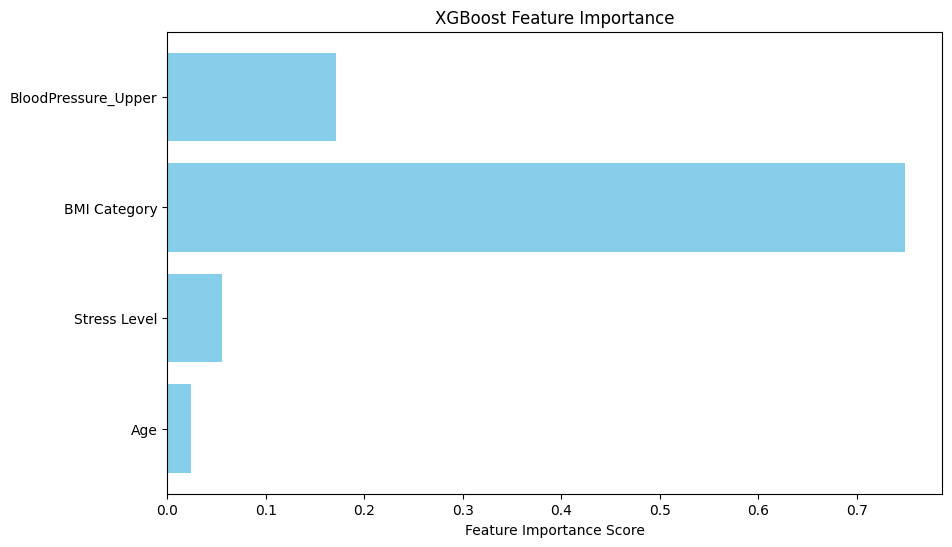

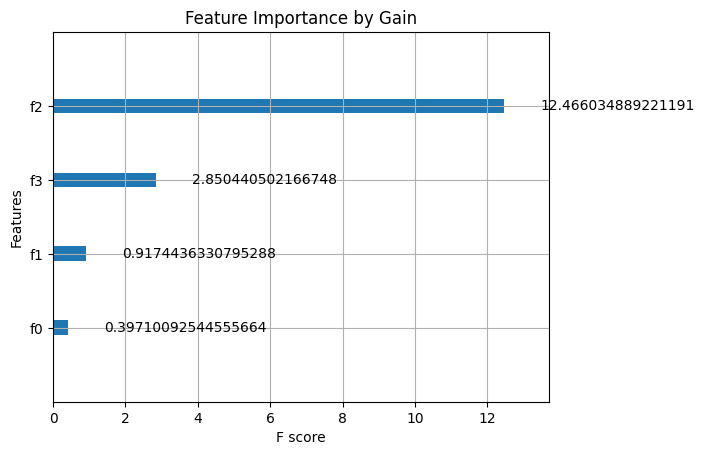

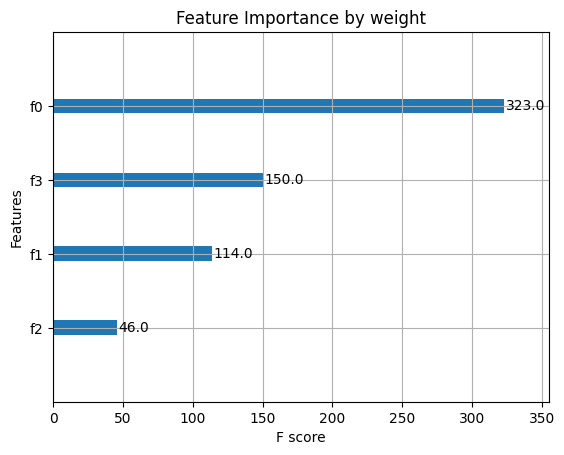

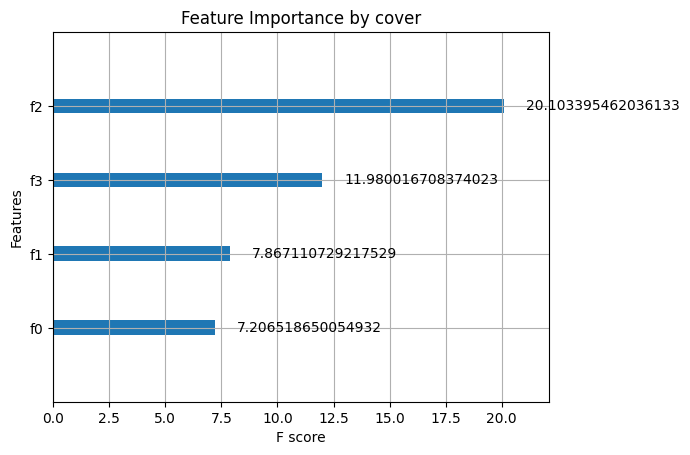

In [41]:
# 使用內建方法顯示特徵重要性
importances = model.feature_importances_

# 視覺化特徵重要性
plt.figure(figsize=(10, 6))
plt.barh(x_feature_names, importances, color="skyblue")
plt.xlabel("Feature Importance Score")
plt.title("XGBoost Feature Importance")
plt.show()

# 內建的特徵重要性圖（基於 Gain）
xgb.plot_importance(model,importance_type="gain", max_num_features=10, title="Feature Importance by Gain")
plt.show()
# 內建的特徵重要性圖（基於 weight）
xgb.plot_importance(model,importance_type="weight", max_num_features=10, title="Feature Importance by weight")
plt.show()
# 內建的特徵重要性圖（基於 weight）
xgb.plot_importance(model,importance_type="cover", max_num_features=10, title="Feature Importance by cover")
plt.show()

In [202]:
data.describe()

Gender         Age  Occupation  Sleep Duration  Quality of Sleep  \
count  374.000000  374.000000  374.000000      374.000000        374.000000   
mean     0.505348   42.184492    2.986631        7.132086          2.326203   
std      0.500641    8.673133    2.053528        0.795657          1.164952   
min      0.000000   27.000000    0.000000        5.800000          0.000000   
25%      0.000000   35.250000    1.000000        6.400000          1.000000   
50%      1.000000   43.000000    3.000000        7.200000          2.000000   
75%      1.000000   50.000000    4.000000        7.800000          3.000000   
max      1.000000   59.000000    7.000000        8.500000          4.000000   

       Physical Activity Level  Stress Level  BMI Category  Heart Rate  \
count               374.000000    374.000000    374.000000  374.000000   
mean                  1.973262      5.385027      0.422460   70.165775   
std                   1.396791      1.774526      0.494613    4.135676   
min                   0.000000      3.000000      0.000000   65.000000   
25%                   1.000000      4.000000      0.000000   68.000000   
50%                   2.000000      5.000000      0.000000   70.000000   
75%                   3.000000      7.000000      1.000000   72.000000   
max                   4.000000      8.000000      1.000000   86.000000   

       Daily Steps  Sleep Disorder  BloodPressure_Upper  BloodPressure_Lower  
count   374.000000      374.000000           374.000000           374.000000  
mean      1.200535        0.414439           128.553476            84.649733  
std       1.136714        0.493285             7.748118             6.161611  
min       0.000000        0.000000           115.000000            75.000000  
25%       0.000000        0.000000           125.000000            80.000000  
50%       1.000000        0.000000           130.000000            85.000000  
75%       2.000000        1.000000           135.000000            90.000000  
max       3.000000        1.000000           142.000000            95.000000

In [ ]:
import shap

In [17]:
xgb_explainer = shap.TreeExplainer(model=model, data=X_train)
shap_values = xgb_explainer.shap_values(X_test)  # 使用 logit_link
#xgb_explainer = shap.TreeExplainer(model=model, data=X_train, link="logit")
#shap_values = xgb_explainer.shap_values(X_test)
print(shap_values.shape)

(75, 4)


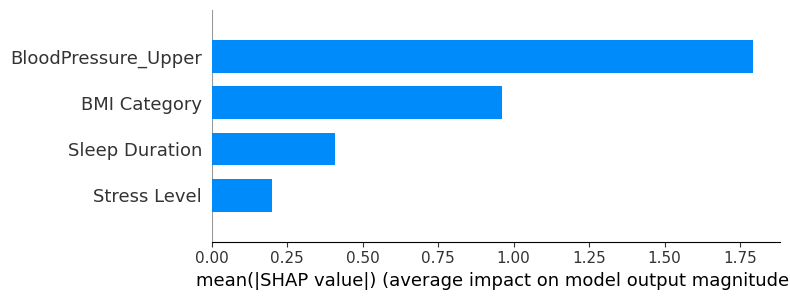

In [18]:
shap.summary_plot(shap_values, X_test, plot_type="bar",
         class_names= y_label_names,
         feature_names = x_feature_names)

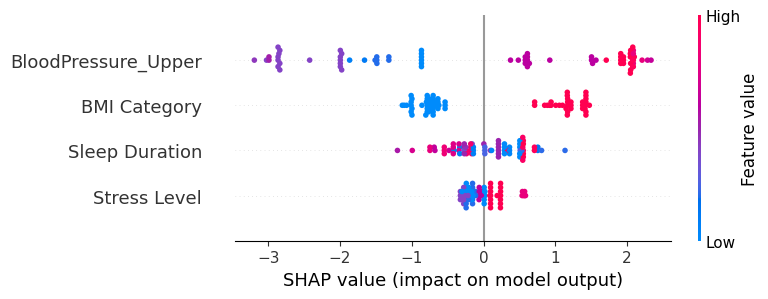

In [20]:
shap.summary_plot(shap_values, X_test,
         class_names= y_label_names,
         feature_names = x_feature_names)

In [21]:
# 觀察測試集中第一筆資料預測為Yes的重要程度
shap.initjs()
index=73
sample = X_test[index:index + 1]
prediction = model.predict(sample)[0]
pred_proba = model.predict_proba(sample)[:, 1]
print(f'測試集第 {index+1} 筆模型原始結果: {y_test[index:index+1]}')
print(f'測試集第 {index+1} 筆模型預測結果: {pred_proba}、label:{prediction}')
shap.force_plot(xgb_explainer.expected_value,
        shap_values[:,:][index],
        X_test[index],
        feature_names=x_feature_names)

測試集第 74 筆模型原始結果: [1]
測試集第 74 筆模型預測結果: [0.94677603]、label:1


array([  6.,   8.,   1., 140.])

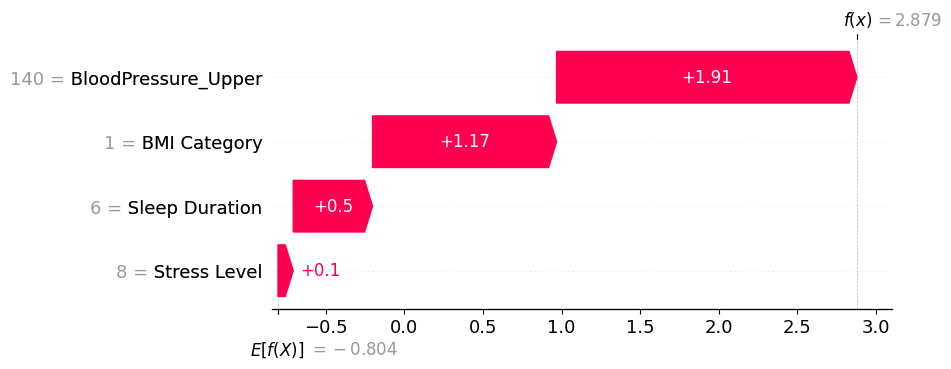

In [22]:
index=73
display(X_test[index,:])
shap.waterfall_plot(shap.Explanation(values=shap_values[:,:][index],
                  base_values=xgb_explainer.expected_value,
                  data=X_test[index,:],
                  feature_names=x_feature_names))

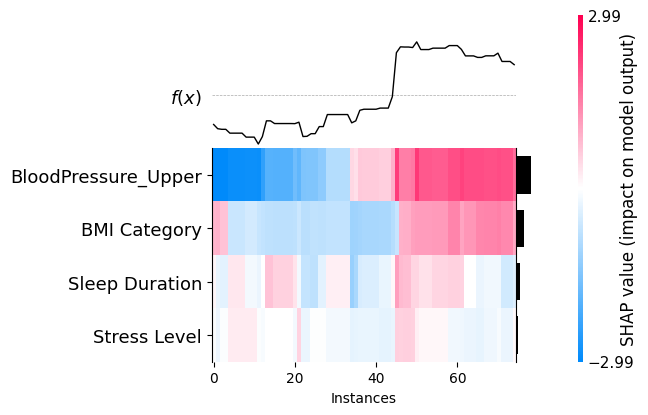

<Axes: xlabel='Instances'>

In [23]:

shap_explanation = shap.Explanation(values=shap_values,
                  base_values=xgb_explainer.expected_value,
                  data=X_test,
                  feature_names=x_feature_names)
shap.plots.heatmap(shap_explanation)

### 篩選錯誤的數據

In [66]:

# 比較預測值與真實值
misclassified_indices = (y_pred != y_test)  # 錯誤分類的布林陣列
# 提取錯誤分類的數據
X_test_misclassified = X_testo[misclassified_indices]
y_test_misclassified = y_test[misclassified_indices]
y_pred_misclassified = y_pred[misclassified_indices]
x_feature_names = data.iloc[:,selected_features].columns
# 將錯誤分類數據整理成表格
misclassified_df = pd.DataFrame(X_test_misclassified, columns=x_feature_names)
#misclassified_df["Actual"] = y_test_misclassified
#misclassified_df["Predicted"] = y_pred_misclassified
misclassified_df

Person ID  Sleep Duration  BMI Category  BloodPressure_Upper
0      145.0             7.1           0.0                130.0
1       68.0             6.0           0.0                125.0
2      360.0             8.1           1.0                140.0
3      202.0             7.8           0.0                130.0

### 分錯類的數據

In [25]:
data_org=pd.read_csv("/content/drive/MyDrive/Sleep_health_and_lifestyle_dataset.csv")

In [67]:
misclassified_data2 = data_org[data_org["Person ID"].isin(misclassified_df["Person ID"].values.tolist())]

misclassified_data2

Person ID  Gender  Age Occupation  Sleep Duration  Quality of Sleep  \
67          68    Male   33     Doctor             6.0                 6   
144        145    Male   38     Lawyer             7.1                 8   
201        202    Male   43   Engineer             7.8                 8   
359        360  Female   59      Nurse             8.1                 9   

     Physical Activity Level  Stress Level BMI Category Blood Pressure  \
67                        30             8       Normal         125/80   
144                       60             5       Normal         130/85   
201                       90             5       Normal         130/85   
359                       75             3   Overweight         140/95   

     Heart Rate  Daily Steps Sleep Disorder  
67           72         5000       Insomnia  
144          68         8000    Sleep Apnea  
201          70         8000       Insomnia  
359          68         7000            NaN

In [28]:
misclassified = misclassified_df.drop(columns=['Person ID']).to_numpy()
shap_values = xgb_explainer.shap_values(misclassified)  # 使用 logit_link
#xgb_explainer = shap.TreeExplainer(model=model, data=X_train, link="logit")
#shap_values = xgb_explainer.shap_values(X_test)
print(shap_values.shape)

(3, 4)


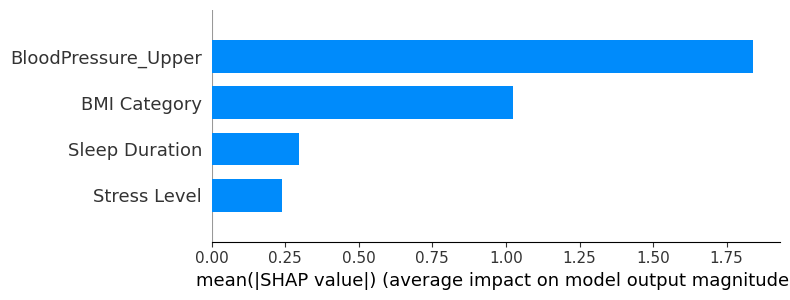

In [29]:
x_feature_names = data.iloc[:,selected_features2].columns
shap.summary_plot(shap_values, misclassified, plot_type="bar",
         class_names= y_label_names,
         feature_names = x_feature_names)

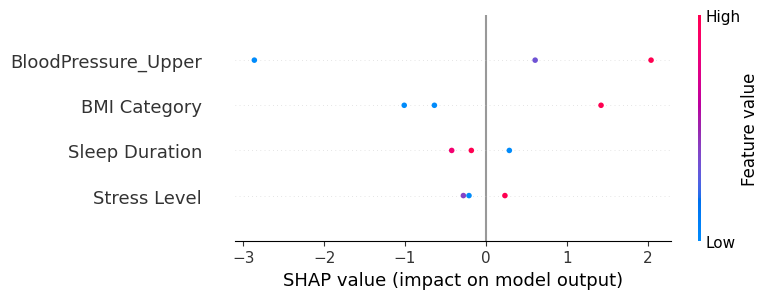

In [30]:
shap.summary_plot(shap_values, misclassified,
         class_names= y_label_names,
         feature_names = x_feature_names)

In [32]:
# 觀察測試集中第一筆資料預測為Yes的重要程度
shap.initjs()
index=2
sample = misclassified[index:index + 1]
prediction = model.predict(sample)[0]
pred_proba = model.predict_proba(sample)[:, 1]
print(f'測試集第 {index+1} 筆模型預測結果: {pred_proba}、label:{prediction}')
shap.force_plot(xgb_explainer.expected_value,
        shap_values[:,:][index],
        misclassified[index],
        feature_names=x_feature_names)

測試集第 3 筆模型預測結果: [0.02238028]、label:0


In [33]:
shap.initjs()
index=2
shap.force_plot(xgb_explainer.expected_value,
        shap_values[:,:][:index],
        misclassified[:index],
        feature_names=x_feature_names)

array([  6.,   8.,   0., 125.])

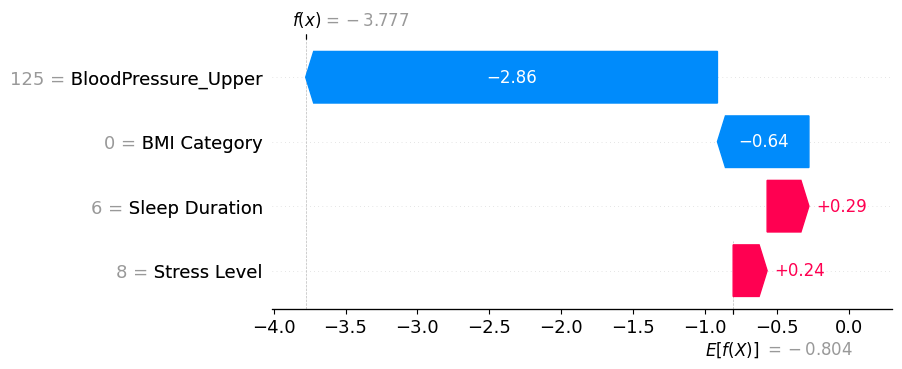

In [34]:
index=2
display(misclassified[index,:])
shap.waterfall_plot(shap.Explanation(values=shap_values[:,:][index],
                  base_values=xgb_explainer.expected_value,
                  data=misclassified[index,:],
                  feature_names=x_feature_names))

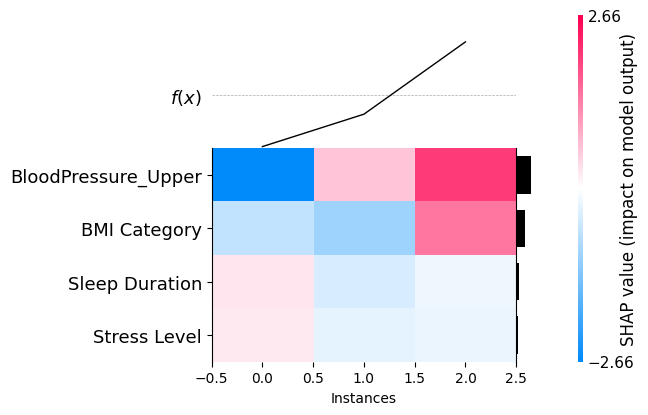

<Axes: xlabel='Instances'>

In [35]:
shap_explanation = shap.Explanation(values=shap_values,
                  base_values=xgb_explainer.expected_value,
                  data=misclassified,
                  feature_names=x_feature_names)
shap.plots.heatmap(shap_explanation)

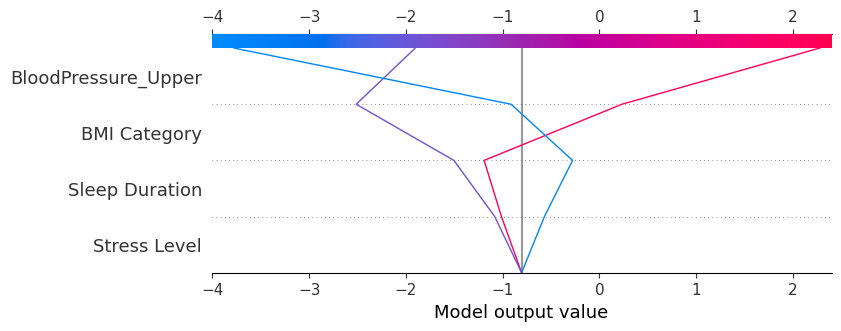

In [36]:
x_feature_names_list = list(x_feature_names)
shap.decision_plot(base_value=xgb_explainer.expected_value,
          shap_values=shap_values,
          features=misclassified,
          feature_names=x_feature_names_list)

## Randomforest 預測

### 全跑特徵

In [ ]:
#讀取資料
data=pd.read_csv("/content/drive/MyDrive/Sleep_health_and_lifestyle_dataset.csv")

In [ ]:
import pandas as pd

# 假設 data 是你的 DataFrame

# 刪除 Person ID
data = data.drop(columns=["Person ID"])

# 把 blood pressure 分成兩個欄位
data[["BloodPressure_Upper", "BloodPressure_Lower"]] = data["Blood Pressure"].str.split("/", expand=True).astype(float)

# 分類 Physical Activity Level
data["Physical Activity Level"] = pd.cut(
    data["Physical Activity Level"],
    bins=[-float("inf"), 35, 45, 60, 75, 90],
    labels=["<=35", "<=45", "<=60", "<=75", "<=90"]
)

# 分類 Daily Steps
data["Daily Steps"] = pd.cut(
    data["Daily Steps"],
    bins=[-float("inf"), 5000, 6000, 7000, float("inf")],
    labels=["<=5000", "<=6000", "<=7000", "7000up"]
)

# 將睡眠疾病轉換為 0 和 1
data["Sleep Disorder"] = data["Sleep Disorder"].apply(lambda x: 0 if pd.isna(x) else 1)

# 分類 BMI
data["BMI Category"] = data["BMI Category"].replace({
    "Normal Weight": "Normal",
    "Obese": "Overweight"
})

# 分類 Quality of Sleep
data["Quality of Sleep"] = data["Quality of Sleep"].apply(lambda x: "4-5" if x in [4, 5] else x)

# 分類 Occupation
data["Occupation"] = data["Occupation"].replace({
    "Manager": "Salesperson",
    "Sales Representative": "Salesperson",
    "Software Engineer": "Engineer"
})
# 刪除 Bloodpressure
data = data.drop(columns=["Blood Pressure"])

In [ ]:
data['Sleep Disorder'] = data['Sleep Disorder'].astype("category")


In [ ]:
categorical_columns = data.select_dtypes(include=["object", "category"]).columns

# 初始化 LabelEncoder
label_encoders = {}

# 對每個類別型欄位進行編碼
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))  # 確保所有值轉為字串處理
    label_encoders[col] = le  # 儲存編碼器以供後續解碼使用

# 檢查結果
print("經過 Label Encoding 的資料：")
print(data.head())

print("\n各欄位的編碼對應：")
for col, le in label_encoders.items():
    print(f"{col}: {list(le.classes_)}")

經過 Label Encoding 的資料：
   Gender  Age  Occupation  Sleep Duration  Quality of Sleep  \
0       1   27           2             6.1                 1   
1       1   28           1             6.2                 1   
2       1   28           1             6.2                 1   
3       1   28           5             5.9                 0   
4       1   28           5             5.9                 0   

   Physical Activity Level  Stress Level  BMI Category  Heart Rate  \
0                        1             6             1          77   
1                        2             8             0          75   
2                        2             8             0          75   
3                        0             8             1          85   
4                        0             8             1          85   

   Daily Steps  Sleep Disorder  BloodPressure_Upper  BloodPressure_Lower  
0            1               0                126.0                 83.0  
1            0       

In [ ]:
data['Sleep Disorder'].unique()

array([0, 1])

In [ ]:
x_feature_names = data.drop(['Sleep Disorder'], axis=1).columns
y_label_names = ['Yes','No']
X = data.drop(['Sleep Disorder'], axis=1).values # 移除y並取得剩下欄位資料
y = data['Sleep Disorder'].values # 取得病人糖尿病結果作為y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
print('train shape:', X_train.shape)
print('test shape:', X_test.shape)

train shape: (187, 12)
test shape: (187, 12)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# 建立 Random Forest 模型
model = RandomForestClassifier(
    n_estimators=500,       # 樹的數量
    max_depth=None,# 最大深度
    max_features=3,
    random_state=42         # 固定隨機種子
)

# 訓練模型
model.fit(X_train, y_train)

# 測試模型
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 模型評估
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"AUC Score: {auc_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9251336898395722
AUC Score: 0.9478158205430933
Confusion Matrix:
[[104   6]
 [  8  69]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       110
           1       0.92      0.90      0.91        77

    accuracy                           0.93       187
   macro avg       0.92      0.92      0.92       187
weighted avg       0.93      0.93      0.92       187



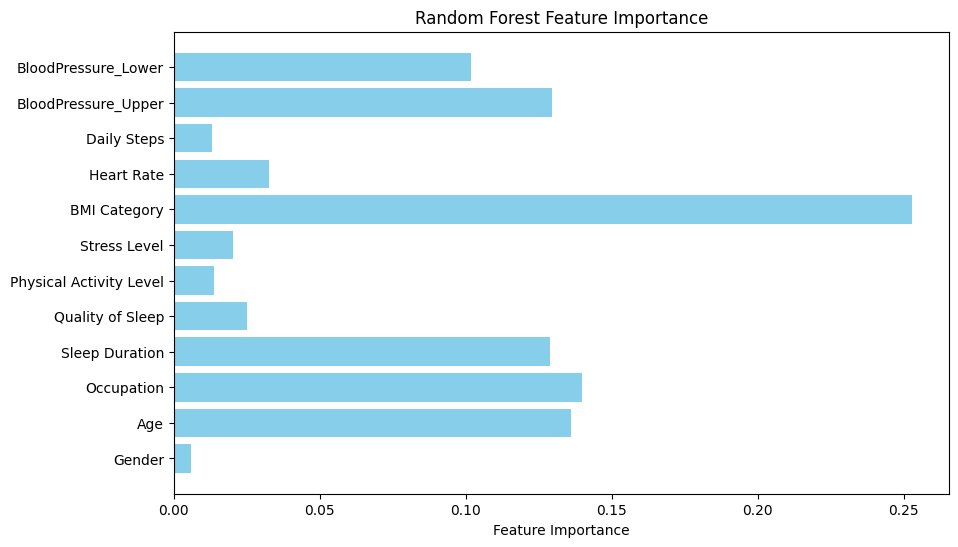

In [ ]:
# 特徵重要性分析
feature_importances = model.feature_importances_

# 視覺化特徵重要性
plt.figure(figsize=(10, 6))
plt.barh(x_feature_names, feature_importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

In [ ]:
rf_explainer = shap.TreeExplainer(model=model, data=X_train)
shap_values = rf_explainer.shap_values(X_test, check_additivity=False)  # 使用 logit_link
#xgb_explainer = shap.TreeExplainer(model=model, data=X_train, link="logit")
#shap_values = xgb_explainer.shap_values(X_test)
print(shap_values.shape)

 97%|=================== | 361/374 [00:13<00:00]       

(187, 12, 2)


In [ ]:
def shap_values_to_list(shap_values, model):
    shap_as_list=[]
    for i in range(len(model.classes_)):
        shap_as_list.append(shap_values[:,:,i])
    return shap_as_list
shap_as_list = shap_values_to_list(shap_values, model)

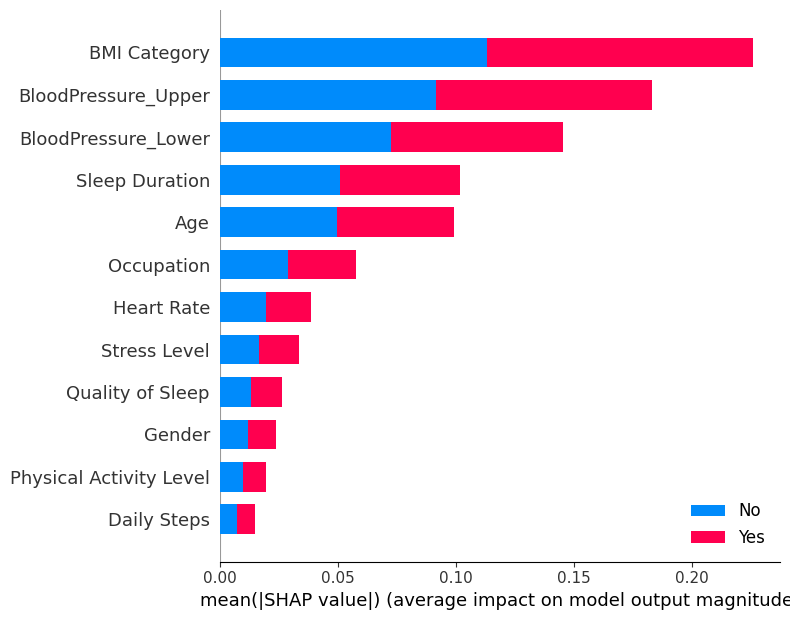

In [ ]:
shap.summary_plot(shap_as_list, X_test, plot_type="bar",
         class_names= y_label_names,
         feature_names = x_feature_names)

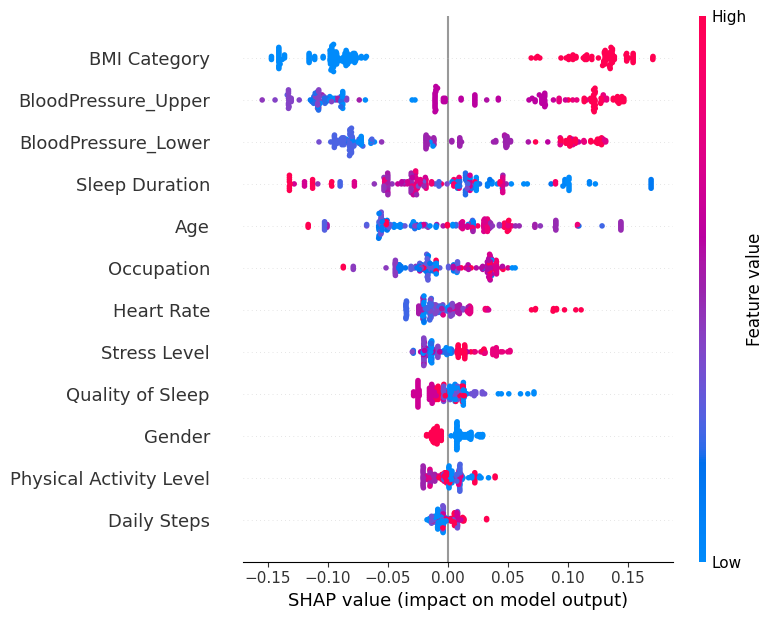

In [ ]:
shap.summary_plot(shap_as_list[1], X_test,
         class_names= y_label_names,
         feature_names = x_feature_names)

In [ ]:

# 觀察測試集中第一筆資料預測為Yes的重要程度
shap.initjs()
index=73
print(f'測試集第 {index+1} 筆模型原始結果: {y_test[index]}')
print(f'測試集第 {index+1} 筆模型預測結果: {model.predict_proba(X_test[[index], :])[0]}')
shap.force_plot(rf_explainer.expected_value[1],
        shap_values[:,:,1][index],
        X_test[index],
        feature_names=x_feature_names, link='logit')

測試集第 74 筆模型原始結果: 1
測試集第 74 筆模型預測結果: [0.002 0.998]


In [ ]:
shap.initjs()
shap.force_plot(rf_explainer.expected_value[1], shap_values[:,:,1][:73], X_test[:73], feature_names=x_feature_names, link='logit')

array([  0. ,  44. ,   7. ,   6.6,   2. ,   1. ,   4. ,   1. ,  65. ,
         2. , 135. ,  90. ])

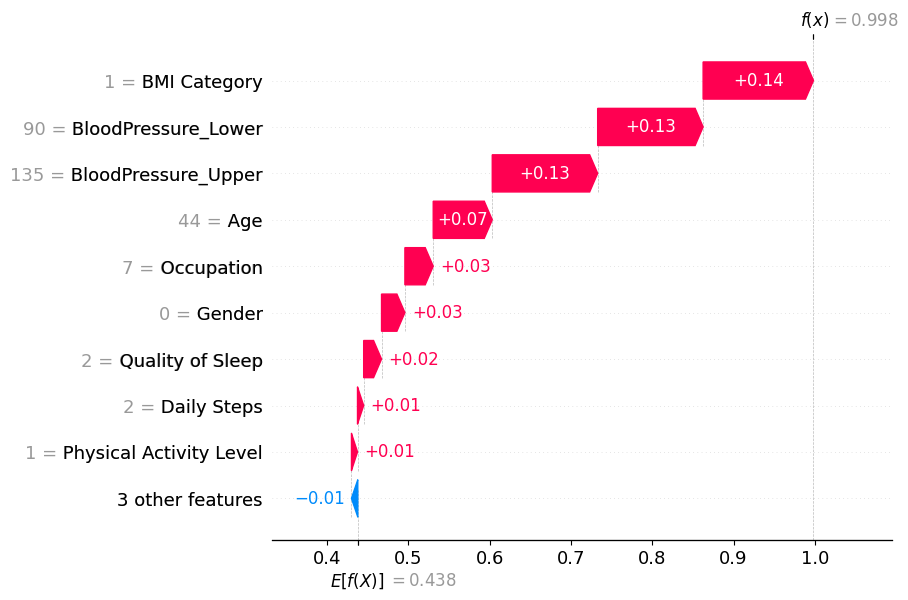

In [ ]:
index=73
display(X_test[index])
shap.waterfall_plot(shap.Explanation(values=shap_values[:,:,1][index],
                  base_values=rf_explainer.expected_value[1],
                  data=X_test[index],
                  feature_names=x_feature_names))

In [ ]:
# 檢查 shap_values 的形狀
print(np.shape(shap_values))  # 應該顯示 (num_samples, num_features)


(187, 12, 2)


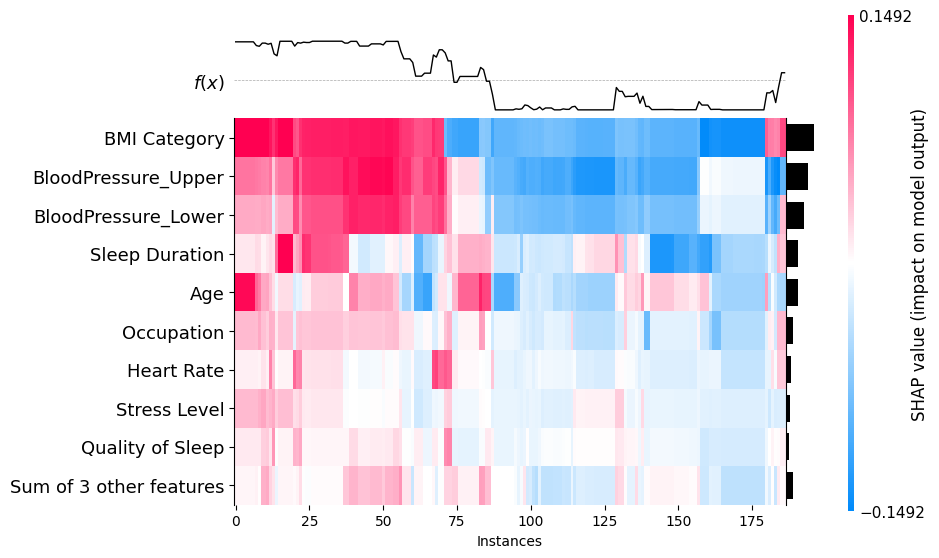

<Axes: xlabel='Instances'>

In [ ]:
shap_explanation = shap.Explanation(values=shap_as_list[1],
                   base_values=rf_explainer.expected_value,
                   data=X_test,
                   feature_names=x_feature_names)
shap.plots.heatmap(shap_explanation)

### 有篩選變數後

In [ ]:
# 假設只選擇部分變數
selected_features = [3,6,7,11] #3,6,7,11 #2,3,7
X_selected = X[:,selected_features]
x_feature_names = data.iloc[:,selected_features].columns
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.5, random_state=42, stratify=y)
print('train shape:', X_train.shape)
print('test shape:', X_test.shape)



train shape: (187, 4)
test shape: (187, 4)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# 建立 Random Forest 模型
model = RandomForestClassifier(
    n_estimators=500,       # 樹的數量
    max_depth=None,# 最大深度
    max_features=3,
    random_state=42         # 固定隨機種子
)

# 訓練模型
model.fit(X_train, y_train)

# 測試模型
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 模型評估
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"AUC Score: {auc_score}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9411764705882353
AUC Score: 0.9521841794569068
Confusion Matrix:
[[106   4]
 [  7  70]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       110
           1       0.95      0.91      0.93        77

    accuracy                           0.94       187
   macro avg       0.94      0.94      0.94       187
weighted avg       0.94      0.94      0.94       187



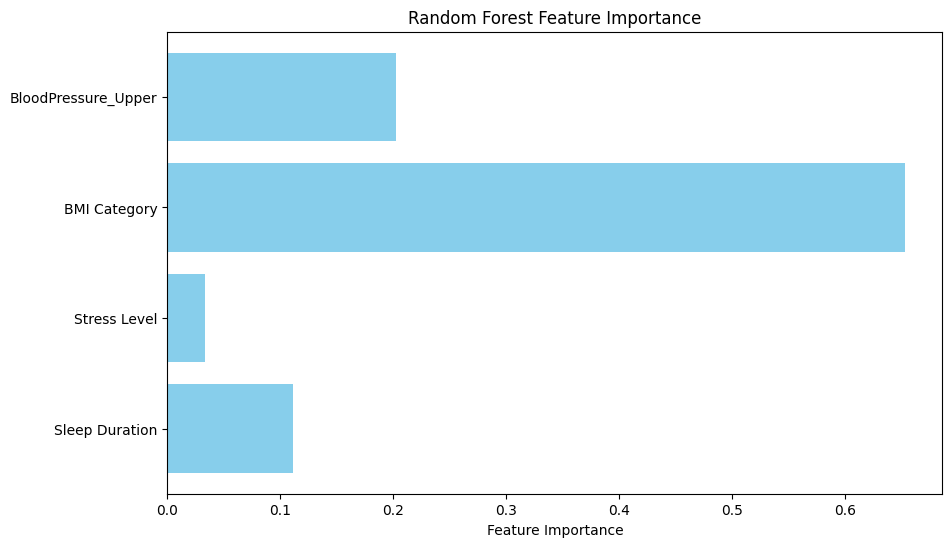

In [ ]:
# 特徵重要性分析
feature_importances = model.feature_importances_

# 視覺化特徵重要性
plt.figure(figsize=(10, 6))
plt.barh(x_feature_names, feature_importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

In [ ]:
rf_explainer = shap.TreeExplainer(model=model, data=X_train)
shap_values = rf_explainer.shap_values(X_test, check_additivity=False)  # 使用 logit_link
#xgb_explainer = shap.TreeExplainer(model=model, data=X_train, link="logit")
#shap_values = xgb_explainer.shap_values(X_test)
print(shap_values.shape)

(187, 4, 2)


In [ ]:
def shap_values_to_list(shap_values, model):
    shap_as_list=[]
    for i in range(len(model.classes_)):
        shap_as_list.append(shap_values[:,:,i])
    return shap_as_list
shap_as_list = shap_values_to_list(shap_values, model)

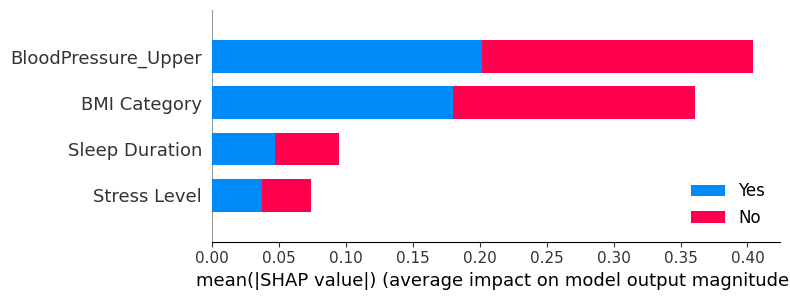

In [ ]:
shap.summary_plot(shap_as_list, X_test, plot_type="bar",
         class_names= y_label_names,
         feature_names = x_feature_names)

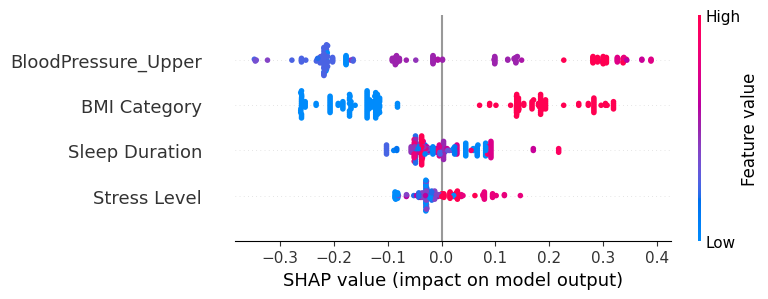

In [ ]:
shap.summary_plot(shap_as_list[1], X_test,
         class_names= y_label_names,
         feature_names = x_feature_names)

In [ ]:

# 觀察測試集中第一筆資料預測為Yes的重要程度
shap.initjs()
index=73
print(f'測試集第 {index+1} 筆模型原始結果: {y_test[index]}')
print(f'測試集第 {index+1} 筆模型預測結果: {model.predict_proba(X_test[[index], :])[0]}')
shap.force_plot(rf_explainer.expected_value[1],
        shap_values[:,:,1][index],
        X_test[index],
        feature_names=x_feature_names, link='logit')

測試集第 74 筆模型原始結果: 1
測試集第 74 筆模型預測結果: [0.25554751 0.74445249]


In [ ]:
shap.initjs()
shap.force_plot(rf_explainer.expected_value[1], shap_values[:,:,1][:73], X_test[:73], feature_names=x_feature_names, link='logit')

array([ 6.6,  4. ,  1. , 90. ])

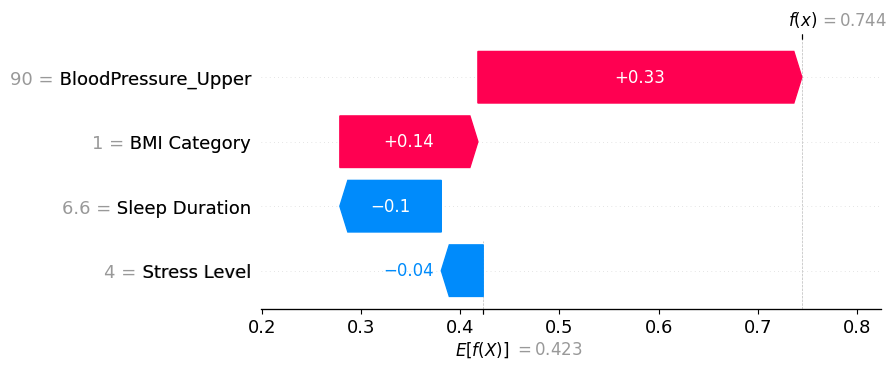

In [ ]:
index=73
display(X_test[index])
shap.waterfall_plot(shap.Explanation(values=shap_values[:,:,1][index],
                  base_values=rf_explainer.expected_value[1],
                  data=X_test[index],
                  feature_names=x_feature_names))

In [ ]:
# 檢查 shap_values 的形狀
print(np.shape(shap_values))  # 應該顯示 (num_samples, num_features)


(187, 4, 2)


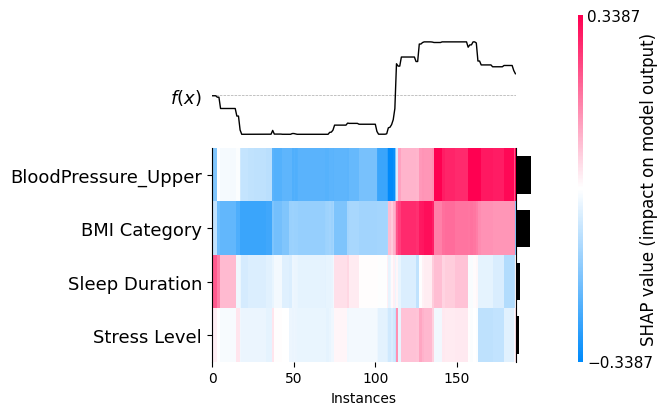

<Axes: xlabel='Instances'>

In [ ]:
shap_explanation = shap.Explanation(values=shap_as_list[1],
                   base_values=rf_explainer.expected_value,
                   data=X_test,
                   feature_names=x_feature_names)
shap.plots.heatmap(shap_explanation)